# <font color=navy> 6-1. A/B Test: Bayesian Estimation Supersedes the T-Test (BEST)</font>


<img src="https://christopher-germann.de/wp-content/uploads/BESThist1.jpg">

- Outlier를 고려하기 위해 정규분포가 꼬리가 두꺼운 non-central t-분포에서 데이터가 발생했다고 가정 (𝜈=자유도)
    $$ y_{1i}\sim t(\mu_1, \sigma_1,\nu)$$
    $$ y_{2i}\sim t(\mu_2, \sigma_2,\nu)$$
- $\mu_i$: 충분히 큰 표준편차를 가진 정규분포에서 발생했다고 가정 
    $$ \mu_1 \sim N(\mu_0, \sigma_0^2)$$
    $$ \mu_2 \sim N(\mu_0, \sigma_0^2)$$
- $\sigma_i$: 넓은 구간에서 정의된 uniform distribution에서 발생했다고 가정 
    $$ \sigma_1 \sim Unif(L, H)$$
    $$ \sigma_2 \sim Unif(L, H)$$
- $\nu$: Shifted exponential에서 발생했다고 가정
    $$ \nu-1 \sim Exp(1/29)$$ 

In [2]:
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import matplotlib
import datetime
import collections
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
data_path = "./data/"

In [3]:
session_times = pd.read_csv(data_path + "web_page_data.csv")
session_times.Time = 100 * session_times.Time
session_times.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


In [8]:
timeA = session_times[session_times.Page == 'Page A'].Time
timeB = session_times[session_times.Page == 'Page B'].Time

In [9]:
pooled_mean = session_times.Time.mean()
pooled_std = session_times.Time.std() 
tau = 1./np.sqrt(1000. * pooled_std) # PyMC uses a precision  parameter, 1/sigma**2
# prior는 데이터보다 뚱뚱한? 분포를 만드고 싶다. 그래서 1000을 곱해준 것
# precision함수를 사용하기 때문에 역수를 취해준 것

In [10]:
s_low = pooled_std/1000.
s_high = 1000.*pooled_std

In [24]:
with pm.Model() as model:
    #사전분포
    group1_mean = pm.Normal('group1_mean', mu=pooled_mean, tau=tau)
    group2_mean = pm.Normal('group2_mean', mu=pooled_mean, tau=tau)
    group1_std = pm.Uniform('group1_std', lower=s_low, upper=s_high)
    group2_std = pm.Uniform('group2_std', lower=s_low, upper=s_high)
    nu_minus_1 = pm.Exponential('nu_minus_one', 1/29.) 
    lambda1 = group1_std**-2 #precision(정밀도 - 분산의 역수)
    lambda2 = group2_std**-2
    # likelihood
    group1 = pm.StudentT('PageA', nu=nu_minus_1+1, mu=group1_mean, lam=lambda1, observed=timeA) # nu는 자유도라 최소 1이어야한다
    group2 = pm.StudentT('PageB', nu=nu_minus_1+1, mu=group2_mean, lam=lambda2, observed=timeB) # 그래서 1 더해준 것
    
    # 사후분포는 likelihood 안에서 학습이 된 사전분포가 사후분포가 되는 것이기 때문에 학습한 뒤 사전분포의 이름 그대로 사용하면 된다.

In [25]:
with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)


In [26]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


- `step`이 주어지지 않으면 default로 NUTS sampler를 사용
- No-U-Turn Sampler(NUTS)
    - Hamiltonian Monte Carlo(HMC): MCMC를 개선하여 parameter간 correlation으로 인한 sensitivity를 개선하여 high dimensional case에서 더 효율적으로 모수공간을 탐색하는 알고리즘 
    - HMC의 tuning parameter 중 하나를 제거하여 hand-tuning이 필요하지 않게 개선 


/Users/yeojinchung/.pyenv/versions/teaching_bayesian/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


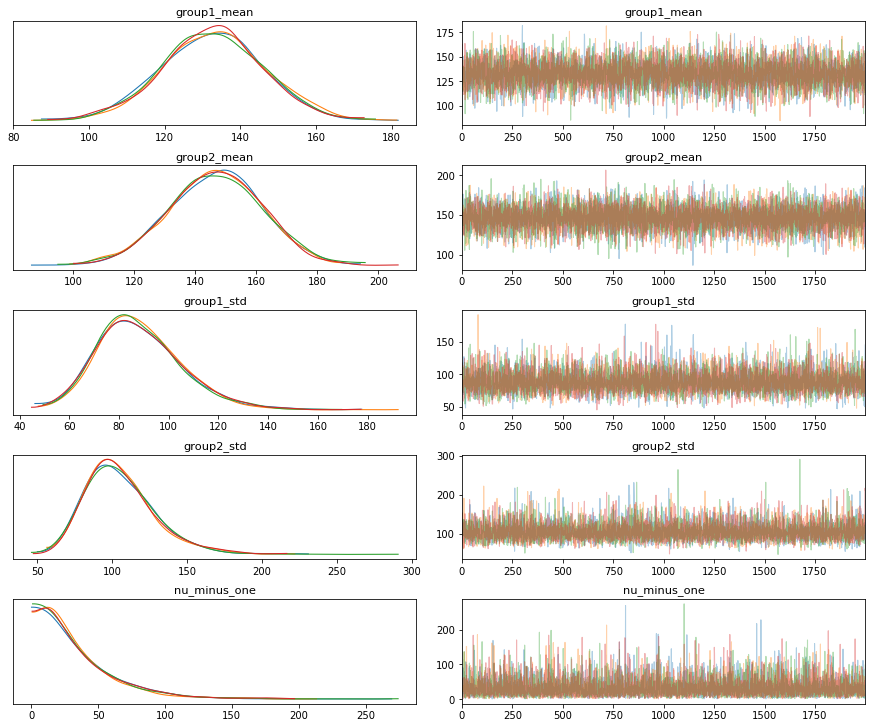

In [27]:
pm.plot_trace(trace,var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'nu_minus_one'] )
plt.show()

/Users/yeojinchung/.pyenv/versions/teaching_bayesian/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


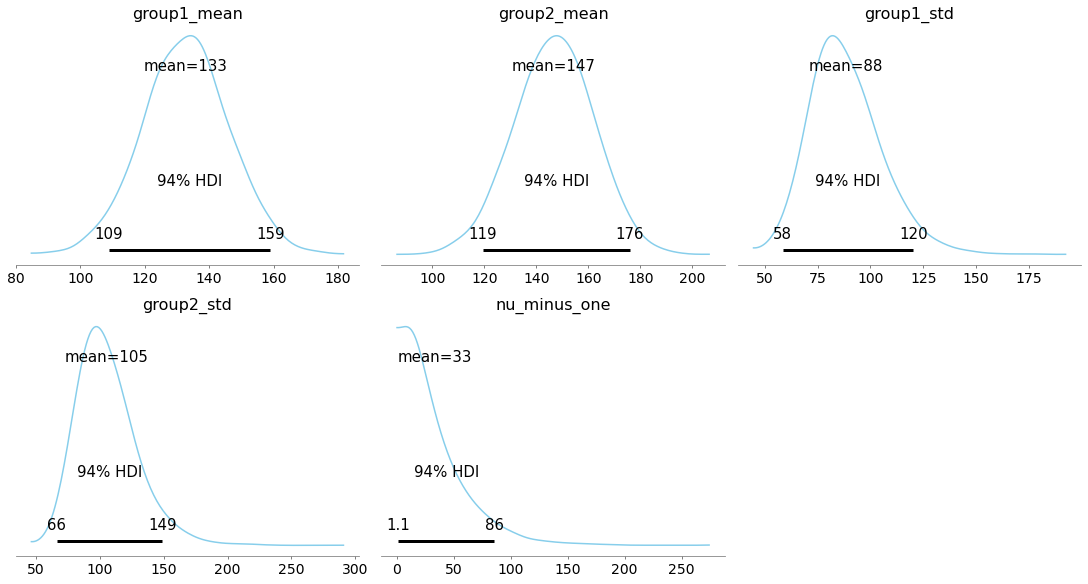

In [28]:
pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'nu_minus_one'],
                  color='#87ceeb', figsize=(15,8))
plt.show()

/Users/yeojinchung/.pyenv/versions/teaching_bayesian/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


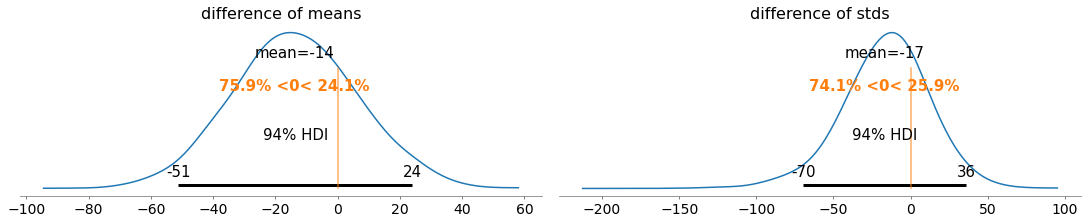

In [29]:
pm.plot_posterior(trace, var_names=['difference of means','difference of stds'
                                   ],
                  ref_val=0, figsize=(15,3))
plt.show()

In [30]:
pm.summary(trace, varnames=['difference of means', 'difference of stds'])


/Users/yeojinchung/.pyenv/versions/teaching_bayesian/lib/python3.7/site-packages/pymc3/stats/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.9
  "pymc3 3.9".format(old=old, new=new)
/Users/yeojinchung/.pyenv/versions/teaching_bayesian/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
difference of means,-13.991,20.011,-51.112,23.919,0.202,0.185,9786.0,5881.0,9781.0,5745.0,1.0
difference of stds,-17.190,28.047,-69.646,35.922,0.297,0.264,8897.0,5654.0,9346.0,5887.0,1.0


#### References
https://pdfs.semanticscholar.org/dea6/0927efbd1f284b4132eae3461ea7ce0fb62a.pdf
